# Introduction


Welcome to the code Notebook for creating a recommender system using Collaborative Filtering.
We will create a book recommendation system using __[Book Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)__ . <br>
We will explore : 
- Neighborhood-based Collaborative Filtering to predict ratings.
- Model-based Collaborative Filtering.

# Import Dataset and explore it

In [2]:
import numpy as np
import pandas as pd

## import datasets


In [3]:
#read BX-Book-Ratings.csv which contains users ratings
ratings_df = pd.read_csv("BX-Book-Ratings.csv", sep=';',encoding = "CP1252")
#modify ratings column's names
ratings_df.columns = ["User_id","ISBN","Rating"]

#read BX-Books.csv which contains users books details
books_info = pd.read_csv("BX-Books.csv", sep=';', usecols=[0,1], escapechar='\\', encoding='CP1252', 
                          low_memory=False)
books_info.columns = ["ISBN","Title"]

#read BX-Users.csv which contains users users details
users_info = pd.read_csv("BX-Users.csv", sep=';',encoding = "CP1252")
users_info.columns = ["User_id","Location","Age"]

Now, let's take a look at the head of these datasets.

In [4]:
ratings_df.head()

,User_id,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [5]:
books_info.head()

,ISBN,Title
0,0195153448,Classical Mythology
1,0002005018,Clara Callan
2,0060973129,Decision in Normandy
3,0374157065,Flu: The Story of the Great Influenza Pandemic...
4,0393045218,The Mummies of Urumchi


In [6]:
users_info.head()

,User_id,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In order to have a clear overview of the book rated, we will merge the two datasets: ratings_df and books_info.

In [7]:
#merge book information with ratings
book_ratings = pd.merge(ratings_df,books_info,on='ISBN')
#check that title column is added
book_ratings.head()

,User_id,ISBN,Rating,Title
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


Let's have a look on our dataset size, number of users and items.

In [8]:
print("The number of rows in Book-Crossing dataset is: " + str(len(book_ratings)))

The number of rows in Book-Crossing dataset is: 1031175


In [9]:
n_users = book_ratings.User_id.nunique()
n_items = book_ratings.ISBN.nunique()

print("The number of users in Book-Crossing Dataset is: "+ str(n_users))
print("The number of books in Book-Crossing Dataset is: "+ str(n_items))

#sparsity
sparsity = float(len(book_ratings[book_ratings["Rating"]!=0]))
sparsity /= (book_ratings.shape[0] * book_ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

The number of users in Book-Crossing Dataset is: 92107
The number of books in Book-Crossing Dataset is: 270170
Sparsity: 9.31%


As you can see, we have a large dataset. As neighborhood methods are very slow in performing on large datasets and in order to avoid running on MemoryError. We will limit our Dataset to only consider users in Germany.

Step1: merge users_info DataFrame with book_ratings DataFrame 

Step 2: Filter users

In [10]:
combined_ratings_info = pd.merge(book_ratings,users_info,on='User_id')
combined_ratings_info.head()

,User_id,ISBN,Rating,Title,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,"tyler, texas, usa",NaN
1,2313,034545104X,5,Flesh Tones: A Novel,"cincinnati, ohio, usa",23.0
2,2313,0812533550,9,Ender's Game (Ender Wiggins Saga (Paperback)),"cincinnati, ohio, usa",23.0
3,2313,0679745580,8,In Cold Blood (Vintage International),"cincinnati, ohio, usa",23.0
4,2313,0060173289,9,Divine Secrets of the Ya-Ya Sisterhood : A Novel,"cincinnati, ohio, usa",23.0


In [11]:
#Filter to only users in Germany
filter_ratings = combined_ratings_info.loc[combined_ratings_info['Location'].str.contains("germany")].copy()
#filter_ratings["Book_index"] = filter_ratings.groupby('ISBN', sort=False).ngroup() + 1
isbn_list = list(filter_ratings.ISBN.unique())
filter_ratings['ISBN'] = filter_ratings.ISBN.astype('category', categories=isbn_list).cat.codes
filter_ratings["User_index"] = filter_ratings.groupby('User_id', sort=False).ngroup() + 1
filter_ratings = filter_ratings[["User_index","ISBN","Rating","User_id","Title","Location","Age"]]
filter_ratings.head()

,User_index,ISBN,Rating,User_id,Title,Location,Age
38479,1,0,0,39396,The Notebook,"bonn, nordrhein-westfalen, germany",20.0
38480,1,1,0,39396,Alice's Adventures in Wonderland and Through t...,"bonn, nordrhein-westfalen, germany",20.0
38481,1,2,0,39396,Wild Animus,"bonn, nordrhein-westfalen, germany",20.0
38482,1,3,8,39396,Harry Potter and the Sorcerer's Stone (Harry P...,"bonn, nordrhein-westfalen, germany",20.0
38483,1,4,0,39396,Title Kassandra. ErzÃ?Â¤hlung. ( Sammlung Luch...,"bonn, nordrhein-westfalen, germany",20.0


Let's check what became the size, numbers of users and number of items.

In [12]:
print("The number of rows in Book-Crossing dataset is: " + str(len(filter_ratings)))

n_users = filter_ratings.User_id.nunique()
n_items = filter_ratings.ISBN.nunique()

print("The number of users in Book-Crossing Dataset is: "+ str(n_users))
print("The number of books in Book-Crossing Dataset is: "+ str(n_items))

#sparsity
sparsity = float(len(filter_ratings[filter_ratings["Rating"]!=0]))
sparsity /= (filter_ratings.shape[0] * filter_ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

The number of rows in Book-Crossing dataset is: 27666
The number of users in Book-Crossing Dataset is: 5067
The number of books in Book-Crossing Dataset is: 15325
Sparsity: 6.28%


# Memory-based Collaborative Filtering (KNN)

### Step 1: Split the dataset into train/test set

In [13]:
from sklearn.cross_validation import train_test_split
train_data, test_data = train_test_split(filter_ratings, test_size=0.20)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
def train_test_matrix(n_users,n_items):
    train_data_matrix = np.zeros((n_users, n_items))
    for line in train_data.itertuples():
        train_data_matrix[line[1]-1, line[2]-1] = line[3]
        
    test_data_matrix = np.zeros((n_users, n_items))
    for line in test_data.itertuples():
        test_data_matrix[line[1]-1, line[2]-1] = line[3]
    
    return train_data_matrix,test_data_matrix
    

In [16]:
train_data_matrix,test_data_matrix = train_test_matrix(n_users,n_items)

### Step 2: Calculate item-similary & user-similarity

We will calculate similarity using cosine similarity.

In [17]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

### Step 3: Predict Similarity using Train Data

In [18]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [19]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

### Step 4: Evaluate the result

In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [21]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 7.68479043099403
Item-based CF RMSE: 7.686326974029178


## Model-Based Collaborative Filtering

In [15]:
# Split the dataframe into a train and test set
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(filter_ratings,test_size=0.20)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [20]:
#Create train set matrix and test set matrix
train_data_matrix,test_data_matrix = train_test_matrix(n_users,n_items)

## Method 1: Stochastic gradient descent

In [21]:
# Scoring Function: Root Mean Squared Error
def rmse_score(R, Q, P):
    I = R != 0  # Indicator function which is zero for missing data
    ME = I * (R - np.dot(P, Q.T))  # Errors between real and predicted ratings
    MSE = ME**2  
    return np.sqrt(np.sum(MSE)/np.sum(I))  # sum of squared errors

In [24]:
# Set parameters and initialize latent factors
f = 20  # Number of latent factor pairs
lmbda = 0.5 # Regularisation strength
gamma=0.01  # Learning rate
n_epochs = 50  # Number of loops through training data
P = 3 * np.random.rand(n_users, f) # Latent factors for users
Q = 3 * np.random.rand(n_items, f) # Latent factors for movies
# Stochastic GD
train_errors = []
test_errors = []
users,items = train_data_matrix.nonzero()  

for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = train_data_matrix[u, i] - np.dot(P[u, :], Q[i, :].T)  # Error for this observation
        P[u, :] += gamma * ( e * Q[i, :] - lmbda * P[u, :]) # Update this user's features
        Q[i, :] += gamma * ( e * P[u, :] - lmbda * Q[i, :])  # Update this movie's features
    train_errors.append(rmse_score(train_data_matrix,Q,P)) # Training RMSE for this pass
    test_errors.append(rmse_score(test_data_matrix,Q,P)) # Test RMSE for this pass


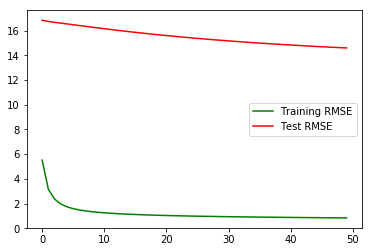

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
# Check performance by plotting train and test errors
fig, ax = plt.subplots()
ax.plot(train_errors, color="g", label='Training RMSE')
ax.plot(test_errors, color="r", label='Test RMSE')
ax.legend()

## Method 2: Batch Gradient Descent

In [33]:
# Set parameters and initialize latent factors
f = 20  # Number of latent factor pairs
lmbda = 50 # Regularisation strength
gamma = 9e-5 # Learning rate
n_epochs = 220  # Number of loops through training data
P = 3 * np.random.rand(n_users, f) # Latent factors for users
Q = 3 * np.random.rand(n_items, f) # Latent factors for movies

# Batch GD
train_errors = []
test_errors = []
for epoch in range(n_epochs): 
    ERR = np.multiply(train_data_matrix != 0, train_data_matrix - np.dot(P, Q.T))  # compute error with present values of Q, P, ZERO if no rating   
#     P += gamma*(np.dot(Q.T, ERR.T).T - lmbda*P)  # update rule
#     Q += gamma*(np.dot(P.T, ERR).T - lmbda*Q)  # update rule
    
    P += gamma*(np.dot(ERR, Q) - lmbda*P)  # update rule
    Q += gamma*(np.dot(ERR.T, P) - lmbda*Q)  # update rule
    
    train_errors.append(rmse_score(train_data_matrix,Q,P)) # Training RMSE for this pass
    test_errors.append(rmse_score(test_data_matrix,Q,P)) # Test RMSE for this pass


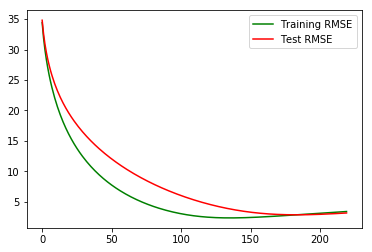

In [34]:
# Check performance by plotting train and test errors
fig, ax = plt.subplots()
ax.plot(train_errors, color="g", label='Training RMSE')
ax.plot(test_errors, color="r", label='Test RMSE')
#snp.labs("Number of Epochs", "RMSE", "Error During Batch GD")
ax.legend()

## Method 3: ALS

In [ ]:
#todo